# Take constrained output for WG3 and put into impulse response form

- Use constrained FaIR setup from 056 and 057
- apply Zeb's conversion
- test

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.twolayermodel import TwoLayerModel

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

## Climate model parameters

### load unconstrained

In [4]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [5]:
accept_inds

array([   838,    949,   1242, ..., 999362, 999380, 999843])

In [6]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
838,9.273214,-1.635251,6.148327,150.303560,0.743663,1.415621
949,8.976294,-1.187633,6.454781,99.281930,0.717200,1.891549
1242,7.607466,-1.621618,9.979336,211.420597,0.643690,1.070795
2110,8.007978,-0.659745,6.944094,55.568035,0.823893,2.067918
2509,9.112583,-1.829337,9.725970,215.461523,0.665151,0.889553
...,...,...,...,...,...,...
999021,8.859442,-1.200989,8.527159,78.088790,0.739437,1.715458
999359,7.638968,-1.265169,8.066919,55.466701,0.515077,0.929718
999362,9.862818,-1.153942,6.061896,162.547532,0.777108,2.955820
999380,8.710426,-0.980681,4.870043,189.856296,0.670366,2.769520


In [7]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# carbon cycle
pre_ind_co2 = pre_ind_co2[accept_inds]
r0 = r0[accept_inds]
rC = rC[accept_inds]
rT = rT[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [10]:
f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

(array([182., 802., 929., 426., 102.,  51.,  44.,  23.,   4.,   2.]),
 array([0.01965245, 0.40516315, 0.79067386, 1.17618456, 1.56169526,
        1.94720597, 2.33271667, 2.71822737, 3.10373808, 3.48924878,
        3.87475949]),
 <BarContainer object of 10 artists>)

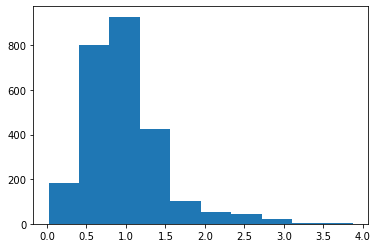

In [11]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [12]:
lamg = geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

## Convert Geoffroy to impulse-response

this is shamelessly copied from Zeb, but indpendence from pint and scm data makes things run 10x faster

In [ ]:
def _calculate_geoffroy_helper_parameters(
    cmix, cdeep, lambda0, efficacy, eta
):

    b_pt1 = (lambda0 + efficacy * eta) / (C)
    b_pt2 = (eta) / (C_D)
    b = b_pt1 + b_pt2
    b_star = b_pt1 - b_pt2
    delta = b ** 2 - (4 * lambda0 * eta) / (C * C_D)

    taucoeff = C * C_D / (2 * lambda0 * eta)
    d1 = taucoeff * (b - delta ** 0.5)
    d2 = taucoeff * (b + delta ** 0.5)

    phicoeff = C / (2 * efficacy * eta)
    phi1 = phicoeff * (b_star - delta ** 0.5)
    phi2 = phicoeff * (b_star + delta ** 0.5)

    adenom = C * (phi2 - phi1)
    a1 = d1 * phi2 * lambda0 / adenom
    a2 = -d2 * phi1 * lambda0 / adenom

    qdenom = cmix * (phi2 - phi1)
    q1 = d1 * phi2 / qdenom
    q2 = -d2 * phi1 / qdenom

out = {
    "d1": d1,
    "d2": d2,
    "q1": q1,
    "q2": q2,
    "efficacy": self.efficacy,
}
    
    out = {
        "b": b,
        "b_star": b_star,
        "delta": delta,
        "tau1": tau1,
        "tau2": tau2,
        "phi1": phi1,
        "phi2": phi2,
        "a1": a1,
        "a2": a2,
    }

    return out



gh = _calculate_geoffroy_helper_parameters(
    cmix, cdeep, lambda0, efficacy, eta
)

